In [31]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from lightgbm import LGBMClassifier

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-credit-default-risk/sample_submission.csv
/kaggle/input/home-credit-default-risk/bureau_balance.csv
/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv
/kaggle/input/home-credit-default-risk/application_train.csv
/kaggle/input/home-credit-default-risk/HomeCredit_columns_description.csv
/kaggle/input/home-credit-default-risk/application_test.csv
/kaggle/input/home-credit-default-risk/previous_application.csv
/kaggle/input/home-credit-default-risk/credit_card_balance.csv
/kaggle/input/home-credit-default-risk/installments_payments.csv
/kaggle/input/home-credit-default-risk/bureau.csv


In [10]:
train = pd.read_csv("/kaggle/input/home-credit-default-risk/application_train.csv")
test = pd.read_csv("/kaggle/input/home-credit-default-risk/application_test.csv")
sample_submission = pd.read_csv("/kaggle/input/home-credit-default-risk/sample_submission.csv")

In [11]:
pd.options.display.max_columns = 200

In [12]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


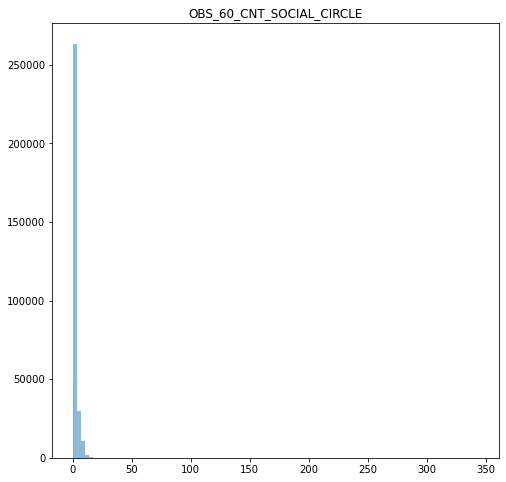

In [13]:
plt.figure(figsize= (8,8))
plt.hist(train['OBS_60_CNT_SOCIAL_CIRCLE'], bins = 100, label = 'test', alpha = 0.5)
plt.hist(np.log1p(train['OBS_60_CNT_SOCIAL_CIRCLE'].fillna(0)), bins = 100, label = 'train', alpha = 0.5)
plt.title('OBS_60_CNT_SOCIAL_CIRCLE')
plt.show()

In [14]:
target = train['TARGET']

num_features = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'FLAG_MOBIL', 
            'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 
                'EXT_SOURCE_2', 'FLAG_DOCUMENT_3', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH']
cat_features = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']

In [15]:
for i, feature in enumerate(num_features):
    train[feature].fillna(0, inplace = True)
    
for i, feature in enumerate(cat_features):
    train[feature].fillna(0, inplace = True)

In [16]:
scaler = MinMaxScaler()
features_transform = pd.DataFrame(data = train)
features_transform[num_features] = scaler.fit_transform(train[num_features])
display(features_transform.head(n = 5))

scale_train = train[num_features]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,0.001512,0.090287,0.095729,0.086667,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,0.888839,0.045086,0.852140,0.705433,NaN,1.0,1.0,0.0,1.0,1.0,0.0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.307542,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,0.002089,0.311736,0.138353,0.278889,Family,State servant,Higher education,Married,House / apartment,0.003541,0.477114,0.043648,0.951929,0.959566,NaN,1.0,1.0,0.0,1.0,1.0,0.0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.727773,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,0.000358,0.022472,0.026160,0.033333,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,0.348534,0.046161,0.827335,0.648326,26.0,1.0,1.0,1.0,1.0,1.0,0.0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.650190,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [17]:
scale_train.head()

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,EXT_SOURCE_2,FLAG_DOCUMENT_3,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH
0,0.001512,0.090287,0.095729,0.086667,1.0,1.0,0.0,1.0,1.0,0.0,0.307542,1.0,0.888839,0.045086,0.852140,0.705433
1,0.002089,0.311736,0.138353,0.278889,1.0,1.0,0.0,1.0,1.0,0.0,0.727773,1.0,0.477114,0.043648,0.951929,0.959566
2,0.000358,0.022472,0.026160,0.033333,1.0,1.0,1.0,1.0,1.0,0.0,0.650190,0.0,0.348534,0.046161,0.827335,0.648326
3,0.000935,0.066837,0.115053,0.073333,1.0,1.0,0.0,1.0,0.0,0.0,0.760751,1.0,0.350846,0.038817,0.601451,0.661387
4,0.000819,0.116854,0.084742,0.126667,1.0,1.0,0.0,1.0,0.0,0.0,0.377472,0.0,0.298591,0.038820,0.825268,0.519522


In [18]:
new_train = scale_train #pd.concat([scale_train, cat_train], axis = 1)
features = num_features#+ new_cat_features

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    train, train['TARGET'], test_size=0.33, random_state=42)

### Гиперпараметры

n_estimators=[10, 20, .., 100]  
max_depth = [1, 2, .., 10]  
num_leaves = [10, 20, .., 100]  

0.6769911255504995 0.6773953717207386
0.6894734788788013 0.6887857676699031
0.6958076315290276 0.6933804781132575
0.6999835674371698 0.696345023011909
0.7026822181629729 0.6983524130211116
0.7052216935415901 0.7002838113052468
0.7067437267208179 0.701255299425884
0.708250029278976 0.7021889150643149
0.7093846972381663 0.7027235688678386


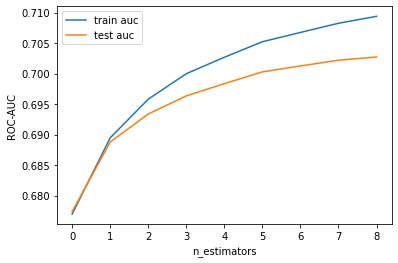

In [20]:
# n_estimators
auc_train_list = []
auc_test_list = []

for est in range(1, 10):
    clf1 = LGBMClassifier(max_depth=3,num_leaves=31, n_estimators=est*10)
    clf1.fit(X_train[features], y_train )
    predict_test = clf1.predict_proba(X_test[features] )[:,1]
    predict_train = clf1.predict_proba(X_train[features] )[:,1]
    
    auc_test = roc_auc_score(y_test, predict_test )
    auc_train = roc_auc_score(y_train, predict_train )
    print(auc_train, auc_test )
    
    auc_train_list.append(auc_train)
    auc_test_list.append(auc_test)
    
plt.plot(auc_train_list, label = 'train auc')
plt.plot(auc_test_list, label = 'test auc')
plt.xlabel('n_estimators')
plt.ylabel('ROC-AUC')
plt.legend()
plt.show()

0.6795860163606072 0.681728410303968
0.6953920618692353 0.6940450507417366
0.7026822181629729 0.6983524130211116
0.7102710906033345 0.7007749633166533
0.7219244582682586 0.7027339413925815
0.7259333499621832 0.7044345650216793
0.7268885119015256 0.7051807817777112
0.7282798607479058 0.7057945645975149
0.7285211935349816 0.705774941187369


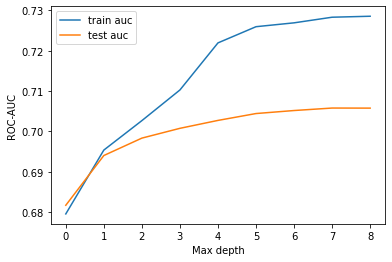

In [21]:
# Max_depth
auc_train_list = []
auc_test_list = []

for m_d in range(1, 10):
    clf2 = LGBMClassifier(max_depth=m_d,num_leaves=31, n_estimators=50)
    clf2.fit(X_train[features], y_train )
    predict_test = clf2.predict_proba(X_test[features] )[:,1]
    predict_train = clf2.predict_proba(X_train[features] )[:,1]
    
    auc_test = roc_auc_score(y_test, predict_test )
    auc_train = roc_auc_score(y_train, predict_train )
    print(auc_train, auc_test )
    
    auc_train_list.append(auc_train)
    auc_test_list.append(auc_test)
    
plt.plot(auc_train_list, label = 'train auc')
plt.plot(auc_test_list, label = 'test auc')
plt.xlabel('Max depth')
plt.ylabel('ROC-AUC')
plt.legend()
plt.show()

0.6795860163606072 0.681728410303968
0.6929849246733665 0.6922692027208374
0.6956403393084547 0.6942627675354937
0.6975244644533379 0.6952211258779754
0.699998850571948 0.6967211680634907
0.7008782234130472 0.6968413847081557
0.7026822181629729 0.6983524130211116
0.7026822181629729 0.6983524130211116
0.7026822181629729 0.6983524130211116
0.7026822181629729 0.6983524130211116
0.7026822181629729 0.6983524130211116
0.7026822181629729 0.6983524130211116
0.7026822181629729 0.6983524130211116
0.7026822181629729 0.6983524130211116
0.7026822181629729 0.6983524130211116
0.7026822181629729 0.6983524130211116
0.7026822181629729 0.6983524130211116
0.7026822181629729 0.6983524130211116
0.7026822181629729 0.6983524130211116
0.7026822181629729 0.6983524130211116
0.7026822181629729 0.6983524130211116
0.7026822181629729 0.6983524130211116
0.7026822181629729 0.6983524130211116
0.7026822181629729 0.6983524130211116
0.7026822181629729 0.6983524130211116
0.7026822181629729 0.6983524130211116
0.702682218162

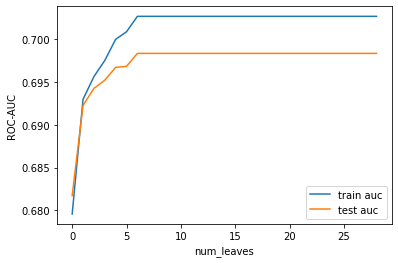

In [22]:
# num_leaves
auc_train_list = []
auc_test_list = []

for n_l in range(2, 31):
    clf3 = LGBMClassifier(max_depth=3,num_leaves=n_l, n_estimators=50)
    clf3.fit(X_train[features], y_train )
    predict_test = clf3.predict_proba(X_test[features] )[:,1]
    predict_train = clf3.predict_proba(X_train[features] )[:,1]
    
    auc_test = roc_auc_score(y_test, predict_test )
    auc_train = roc_auc_score(y_train, predict_train )
    print(auc_train, auc_test )
    
    auc_train_list.append(auc_train)
    auc_test_list.append(auc_test)
    
plt.plot(auc_train_list, label = 'train auc')
plt.plot(auc_test_list, label = 'test auc')
plt.xlabel('num_leaves')
plt.ylabel('ROC-AUC')
plt.legend()
plt.show()

Выводы к подбору гиперпараметров:

1) Ограничение n_estimators позволяет снизить переобучение  
2) При увеличении max_depth растет переобучение, наибольший "разрыв" происходит при глубине более 3. Но также данное ограничение позволяет снизить переобучение при варьировании других гиперпараметров.  
3) При num_leaves > 6 не оказывает влияния на результат (и переобучение), при ограничении num_leavs можно снизить переобучение.  

## Отбор наилучших параметров с помощью GridSearchCV и RandomizedSearchCV 

In [23]:
param_grid = { 'max_depth': range (1,10),
              'num_leaves': range(2, 10),
              'n_estimators': range (10,100,10) }

bm = LGBMClassifier()

In [25]:
grid = GridSearchCV(bm, param_grid, cv=5)
grid.fit(X_train[features], y_train)

print(grid.best_params_)
#{'max_depth': 4, 'n_estimators': 90, 'num_leaves': 8}

{'max_depth': 4, 'n_estimators': 90, 'num_leaves': 8}


In [26]:
n_iter_search = 20
random_search = RandomizedSearchCV(bm, param_grid, cv=5, n_iter = n_iter_search)
random_search.fit(X_train[features], y_train)

print(random_search.best_params_)
#результат {'num_leaves': 9, 'n_estimators': 90, 'max_depth': 6}

{'num_leaves': 9, 'n_estimators': 90, 'max_depth': 6}


## График с лучшими признаками

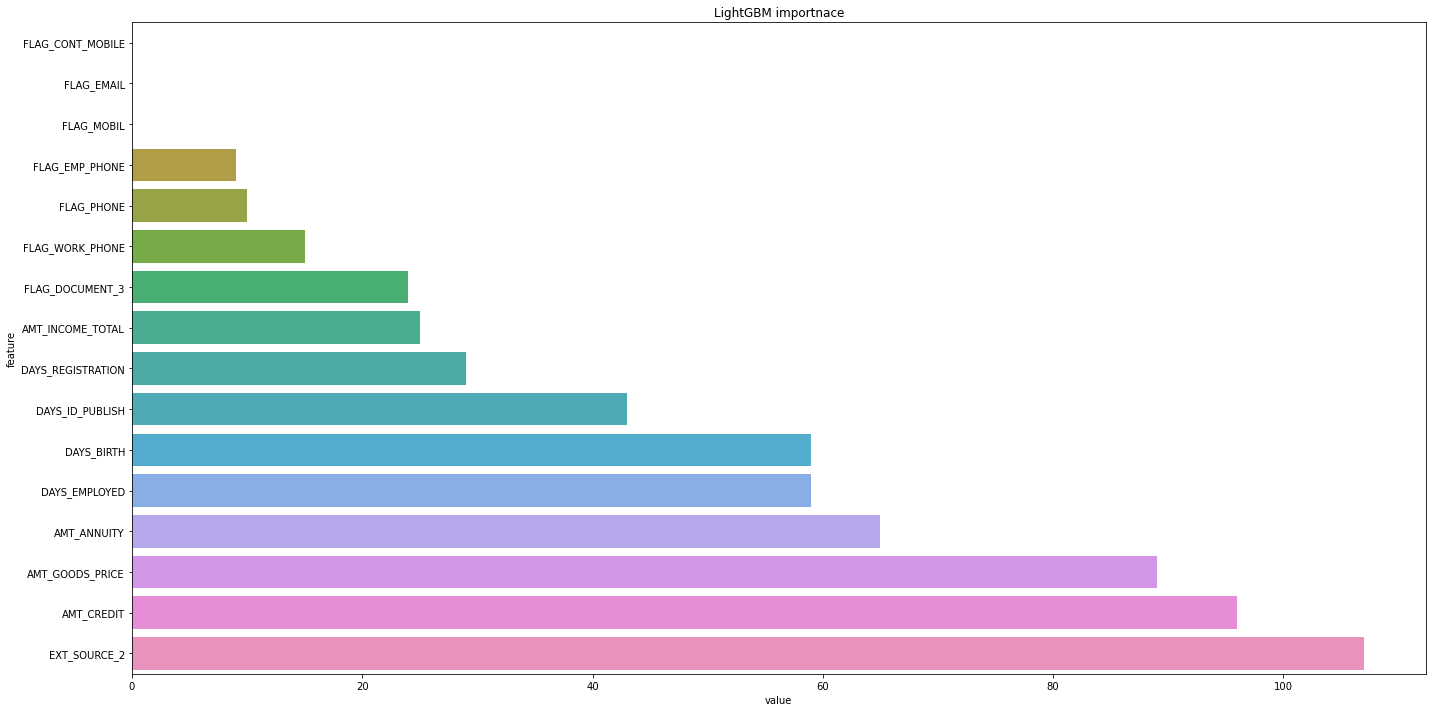

In [27]:
import seaborn as sns

bm = LGBMClassifier(random_state=42, n_estimators=90, max_depth=9, num_leaves=8)
bm.fit(X_train[features], y_train)


feature_imp = pd.DataFrame(sorted(zip(bm.feature_importances_,features)),
                           columns=['value','feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="value", y="feature", data=feature_imp.sort_values(by="value"))
plt.title('LightGBM importnace')
plt.tight_layout()
plt.show()

Наиболее значимыми оказались признаки: EXT_SOURCE_2, AMT_CREDIT, AMT_GOODS_PRICE

### Стейкинг

In [32]:
scaler = StandardScaler()

In [33]:
norm_log_train = pd.DataFrame()
norm_features = []

In [34]:
for i, head in enumerate(features):
    norm_log_train['LOG_'+head] = np.log1p(train[head])
    scaler.fit(norm_log_train[['LOG_'+head]])
    norm_log_train['NORM_LOG_'+head] = scaler.transform(norm_log_train[['LOG_'+head]])
    norm_features.append('NORM_LOG_'+head)
    
print(norm_features)

['NORM_LOG_AMT_INCOME_TOTAL', 'NORM_LOG_AMT_CREDIT', 'NORM_LOG_AMT_ANNUITY', 'NORM_LOG_AMT_GOODS_PRICE', 'NORM_LOG_FLAG_MOBIL', 'NORM_LOG_FLAG_EMP_PHONE', 'NORM_LOG_FLAG_WORK_PHONE', 'NORM_LOG_FLAG_CONT_MOBILE', 'NORM_LOG_FLAG_PHONE', 'NORM_LOG_FLAG_EMAIL', 'NORM_LOG_EXT_SOURCE_2', 'NORM_LOG_FLAG_DOCUMENT_3', 'NORM_LOG_DAYS_BIRTH', 'NORM_LOG_DAYS_EMPLOYED', 'NORM_LOG_DAYS_REGISTRATION', 'NORM_LOG_DAYS_ID_PUBLISH']


In [35]:
# Logistic model
lm = LogisticRegression(max_iter = 1000)
cross = cross_val_score(lm, norm_log_train[norm_features],  y = train['TARGET'], cv = 5, scoring= 'roc_auc')
print("model_1 = {}".format(np.mean(cross)))

#1 model_1 = 0.688537429189523

model_1 = 0.688537429189523


In [37]:
#Randomforest model
fm_1 = RandomForestClassifier(n_estimators = 30, max_depth = 3)
cross = cross_val_score(fm_1, norm_log_train[norm_features],  y = train['TARGET'], cv = 5, scoring= 'roc_auc')
print("model_2 = {}".format(np.mean(cross)))

#2 model_2 = 0.6728491414639208

model_2 = 0.6728491414639208


In [38]:
fm_2 = RandomForestClassifier(n_estimators = 50, max_depth = 4)
cross = cross_val_score(fm_2, norm_log_train[norm_features],  y = train['TARGET'], cv = 5, scoring= 'roc_auc')
print("model_3 = {}".format(np.mean(cross)))

#3 model_3 = 0.6806226739817577

model_3 = 0.6806226739817577


In [39]:
#GradientBoosting model
bm_1 = LGBMClassifier(n_estimators = 90, max_depth = 9, num_leaves = 8)
cross = cross_val_score(bm_1, norm_log_train[norm_features],  y = train['TARGET'], cv = 5, scoring= 'roc_auc')
print("model_4 = {}".format(np.mean(cross)))

#4 model_4 = 0.7017552578621288

model_4 = 0.7017552578621288


In [40]:
bm_2 = LGBMClassifier(n_estimators = 50, max_depth = 4, num_leaves = 4)
cross = cross_val_score(bm_2, norm_log_train[norm_features],  y = train['TARGET'], cv = 5, scoring= 'roc_auc')
print("model_5 = {}".format(np.mean(cross)))

#5 model_5 = 0.6927939614626633

model_5 = 0.6927939614626633


## Стэкинг моделей

In [41]:
estimators = [('fm_1',fm_1 ), ('fm_2',fm_2), ('bm_1',bm_1), ('log', bm_2), ('lm', lm)]
stacking = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression())

cross = cross_val_score(stacking, norm_log_train[norm_features],  y = train['TARGET'], cv = 5, scoring= 'roc_auc')
print(np.mean(cross))

#0.7010420513265796

0.7010420513265796


Стэкинг не смог показать наилучшую метрику, чем при использовании каждой из моделей в отдельности.
GBM в отдельности показал результат лучше

Исключаем из стэкинга модель с наилучшей метрикой на кросс-валидации - bm_1 (градиентный бустинг)

In [42]:
stimators = [('fm_1',fm_1 ), ('fm_2',fm_2), ('log', bm_2), ('lm', lm)]
stacking = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression())

cross = cross_val_score(stacking, norm_log_train[norm_features],  y = train['TARGET'], cv = 5, scoring= 'roc_auc')
print(np.mean(cross))

# 0.7010898076271973

0.7010898076271973


Результат ухудшился по причине того, что исключен алгоритм, который чаще указывал на верный результат